In [1]:
import pandas as pd
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import numpy as np
import plotly.express as px

Plot UMAP representations of the ORF profiles

Read all plates in all batches. One plate in Batch 2 and all plates in Batch12 were not included because of experimental anomalies. 

In [2]:
experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Type=="ORF"')
    .query('Anomaly!="other"')
    .query('Batch!="Batch12"')
)

batch_order = ['Batch1', 'Batch2', 'Batch3', 'Batch4', 'Batch5', 'Batch6', 'Batch7', 'Batch8', 'Batch9', 'Batch10', 'Batch11', 'Batch13']
control_order = ['Treatment', 'Negative control', 'Positive control']

color_discrete_map = {
    "Control": {
        "Treatment": "#0072b2",
        "Negative control": "#d55e00",
        "Positive control": "#009e73",
    }
}

all_orf_plates_df = pd.DataFrame()

In [3]:
for batch in experiment_df.Batch.unique():
    batch_df = experiment_df.query('Batch==@batch')
    for platemap in batch_df.Plate_Map_Name.unique():
        platemap_df = batch_df.query('Plate_Map_Name==@platemap')
        for plate in platemap_df.Assay_Plate_Barcode.unique():
            df = (
                utils.load_data(batch, plate, 'normalized_feature_select_negcon_all.csv.gz')
                .assign(Metadata_Batch=batch)
            )
            all_orf_plates_df = utils.concat_profiles(all_orf_plates_df, df)

all_orf_plates_df = utils.remove_empty_wells(all_orf_plates_df)
all_orf_plates_df.shape

(83103, 1479)

Remove `BAD CONSTRUCT` samples

In [4]:
all_orf_plates_df = all_orf_plates_df.query('Metadata_broad_sample!="BAD CONSTRUCT"').reset_index(drop=True)
all_orf_plates_df.shape

(82483, 1479)

Remove featues with `nan` values.

In [5]:
# Remove features with nan

r,c = np.where(all_orf_plates_df.isna())
features_to_remove = [_ for _ in list(all_orf_plates_df.columns[list(set(c))]) if not _.startswith('Metadata_')]
print(f'Removed nan features: {features_to_remove}')
all_orf_plates_df.drop(features_to_remove, axis=1, inplace=True)
all_orf_plates_df.shape

Removed nan features: ['Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_9of16', 'Cells_AreaShape_FormFactor', 'Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_9of16']


(82483, 1476)

Create UMAP

In [6]:
X = utils.get_featuredata(all_orf_plates_df)

umap_2d = UMAP(n_components=2, random_state=9000)
projection_2d = umap_2d.fit_transform(X)

In [7]:
batch_list = list(all_orf_plates_df.Metadata_Batch)
plate_list = list(all_orf_plates_df.Metadata_Plate)
platemap_list = list(all_orf_plates_df.Metadata_plate_map_name)
pert_type_list = list(all_orf_plates_df.Metadata_pert_type)
control_type_list = list(all_orf_plates_df.Metadata_control_type)
control_list = [pert_type_list[_] if pert_type_list[_]=="trt" else control_type_list[_] for _ in range(len(pert_type_list))]

X_embedded_df = pd.DataFrame(
    {
        "Batch": batch_list,
        "Plate": plate_list,
        "Platemap": platemap_list,
        "Control":control_list,
        "umap 1": projection_2d[:, :1].flatten(),
        "umap 2": projection_2d[:, 1:2].flatten(),
    }
)

X_embedded_df = X_embedded_df.sample(frac=1)

X_embedded_df.replace({'trt':'Treatment', 'negcon': 'Negative control', 'poscon': 'Positive control'}, inplace=True)

Create scatter plots

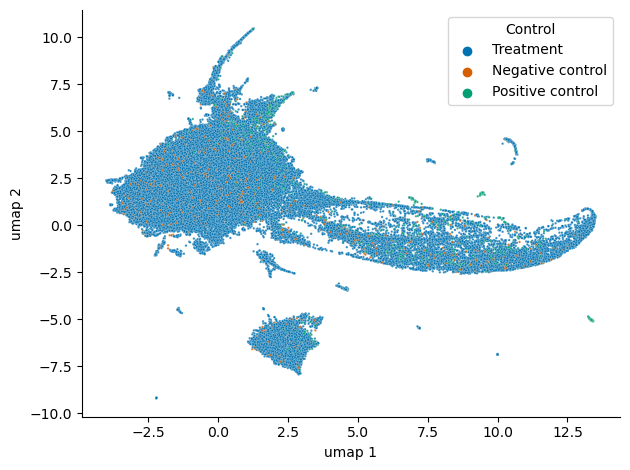

In [8]:
sns.scatterplot(
    data=X_embedded_df,
    x='umap 1', 
    y='umap 2',
    s=3,
    hue=X_embedded_df['Control'],
    hue_order=control_order,
    palette=color_discrete_map["Control"],
    alpha=0.8
)

sns.despine()
plt.tight_layout()
plt.savefig('figures/1.umap-orf-control.png')

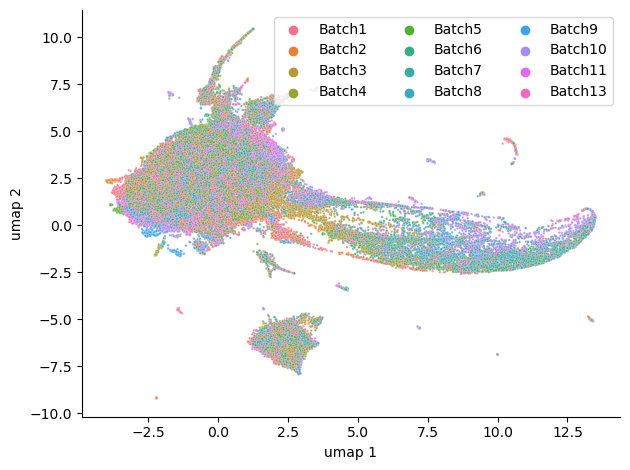

In [9]:
sns.scatterplot(
    data=X_embedded_df,
    x='umap 1', 
    y='umap 2',
    s=3,
    hue=X_embedded_df['Batch'],
    hue_order=batch_order,
    alpha=0.8
)

sns.despine()
plt.legend(ncol=3, loc='upper right')
plt.tight_layout()
plt.savefig('figures/1.umap-orf-batch.png')

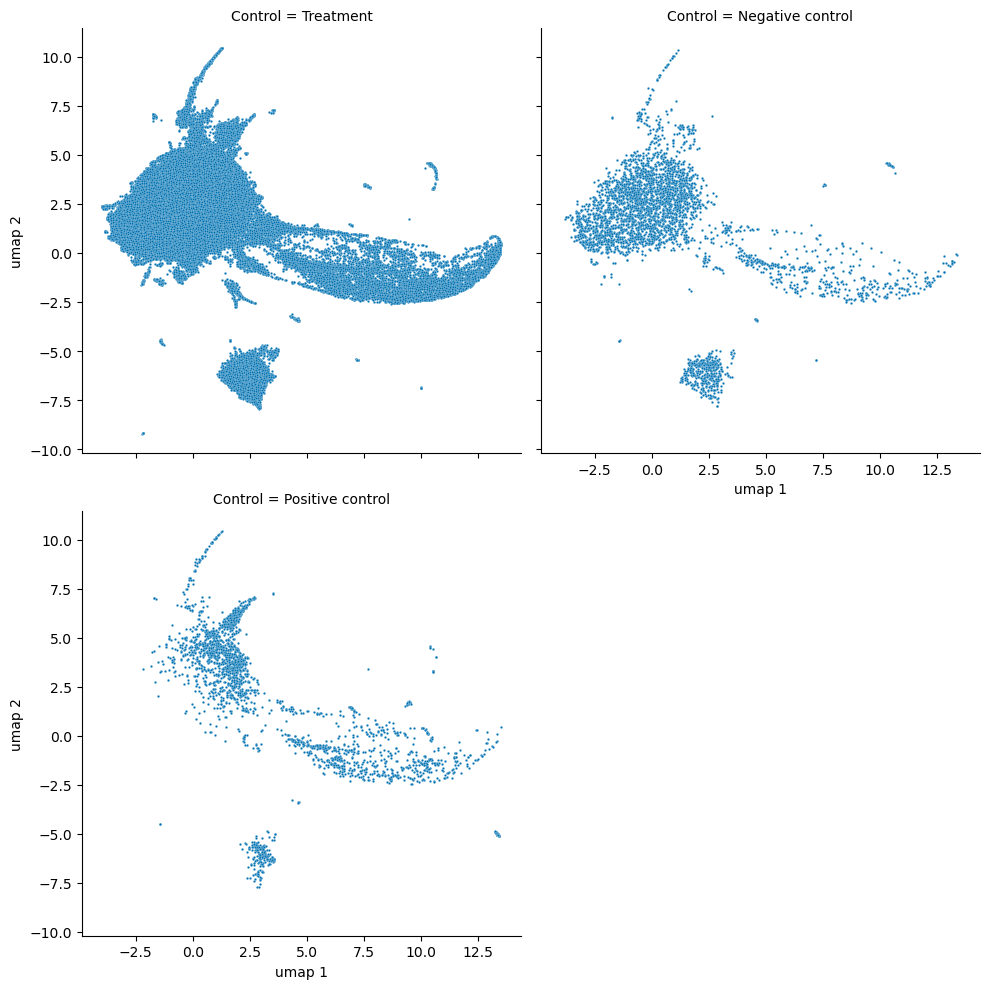

In [10]:
g = sns.relplot(
    data=X_embedded_df,
    x='umap 1',
    y='umap 2',
    kind='scatter',
    color="#0072b2",
    col=X_embedded_df["Control"],
    col_order=control_order,
    col_wrap=2,
    s=3
)

sns.despine()
plt.tight_layout()
plt.savefig('figures/1.umap-orf-control-separated.png')

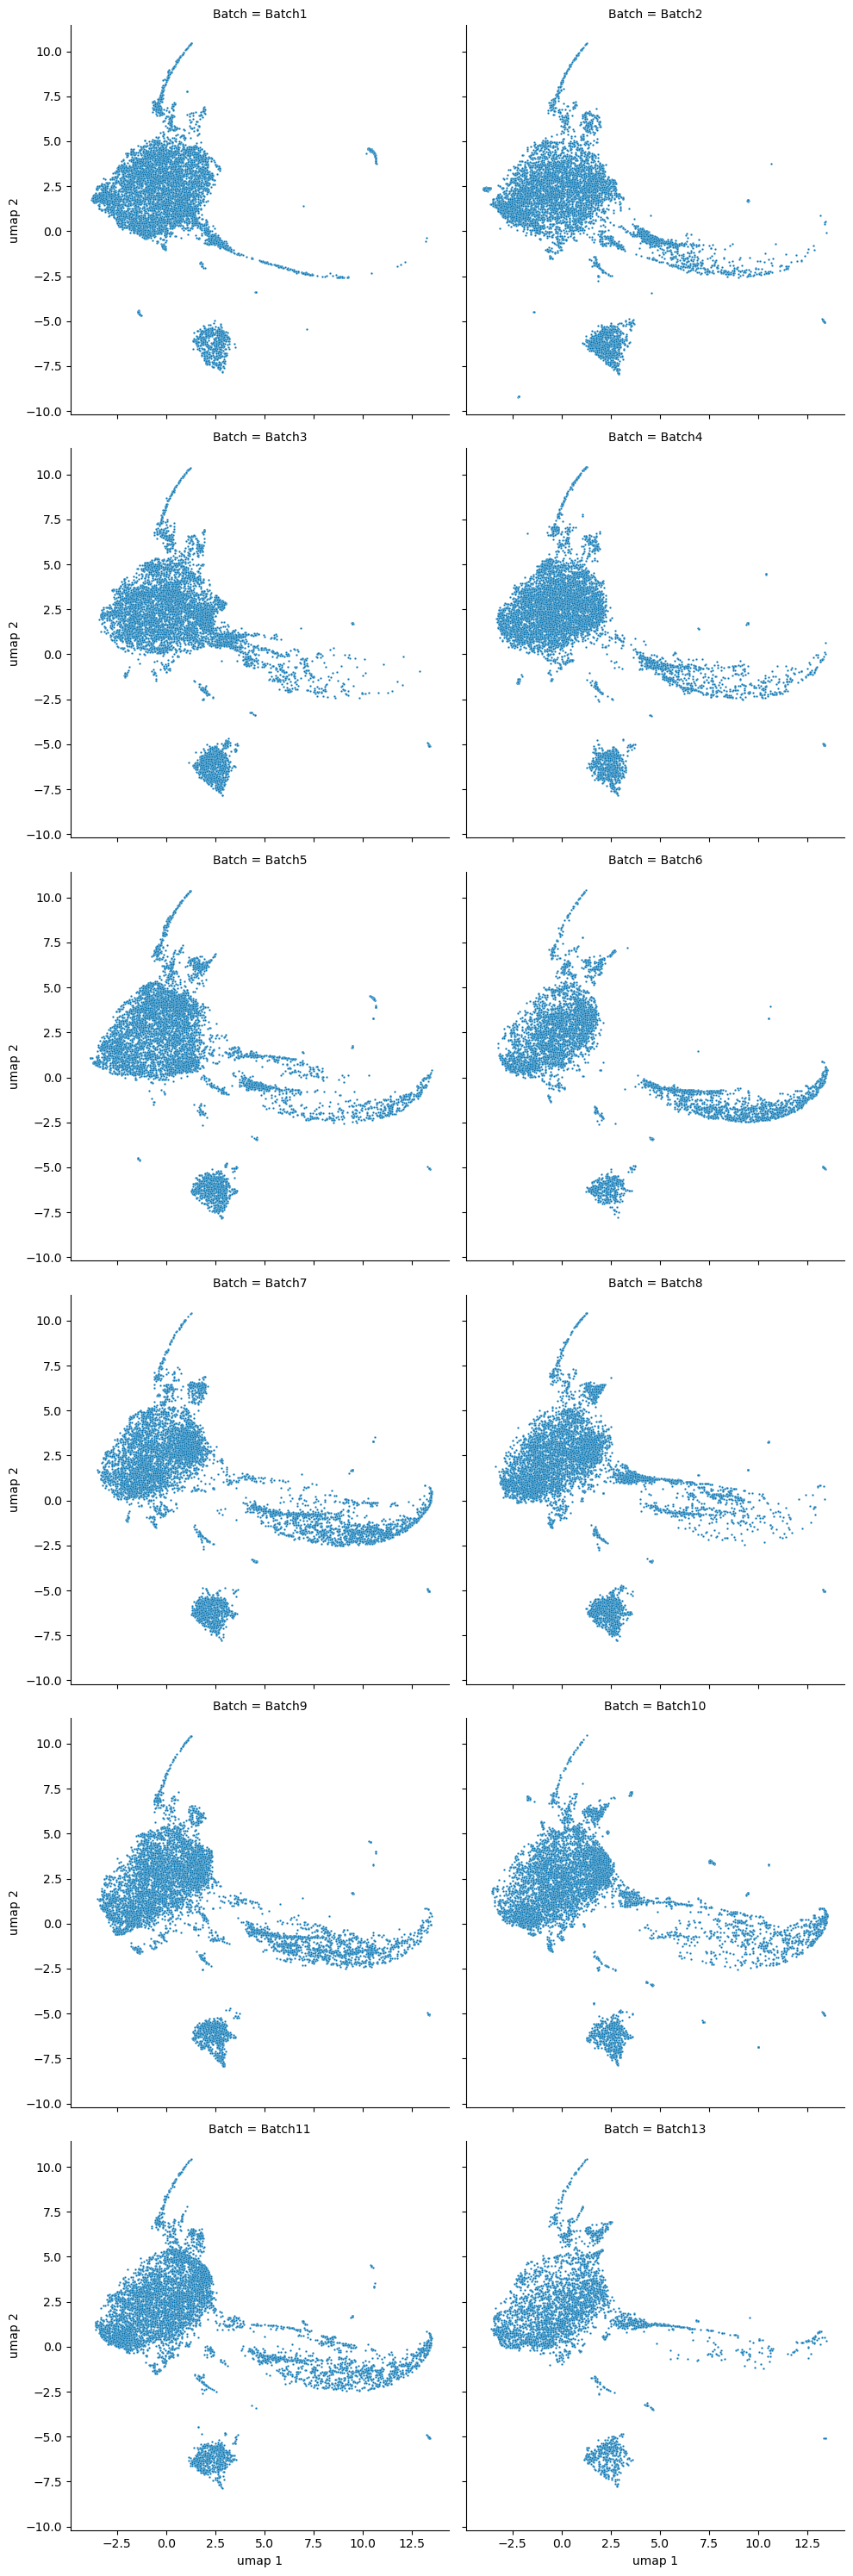

In [11]:
g = sns.relplot(
    data=X_embedded_df,
    x='umap 1',
    y='umap 2',
    kind='scatter',
    color="#0072b2",
    col=X_embedded_df["Batch"],
    col_order=batch_order,
    col_wrap=2,
    s=3
)

sns.despine()
plt.tight_layout()
plt.savefig('figures/1.umap-orf-batch-separated.png')